In [1]:
import os
import json
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# ==== Step 0: Set paths ====
real_folder = r"C:\Users\ccqer\Downloads\KaiDMML FakeNewsNet old-version Data-PolitiFact_RealNewsContent"
fake_folder = r"C:\Users\ccqer\Downloads\KaiDMML FakeNewsNet old-version Data-PolitiFact_FakeNewsContent"
news_user_file = r"C:\Users\ccqer\Downloads\PolitiFactNewsUser.txt"
news_list_file = r"C:\Users\ccqer\Downloads\News.txt"

# ==== Step 1: Build mapping from News.txt to JSON filenames ====
real_ids = sorted([f.replace(".json", "") for f in os.listdir(real_folder) if f.endswith(".json")])
fake_ids = sorted([f.replace(".json", "") for f in os.listdir(fake_folder) if f.endswith(".json")])

ordered_ids = []
with open(news_list_file, "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith("PolitiFact_Real"):
            index = int(line.split("_")[-1]) - 1
            if index < len(real_ids):
                nid = real_ids[index]
                ordered_ids.append((line, nid, 0))  # label 0 = real
        elif line.startswith("PolitiFact_Fake"):
            index = int(line.split("_")[-1]) - 1
            if index < len(fake_ids):
                nid = fake_ids[index]
                ordered_ids.append((line, nid, 1))  # label 1 = fake

# ==== Step 2: Load article text and build index mapping ====
texts, labels, news_id_to_idx = [], [], {}

for name, nid, label in ordered_ids:
    folder = real_folder if label == 0 else fake_folder
    try:
        with open(os.path.join(folder, nid + ".json"), "r", encoding="utf-8") as f:
            data = json.load(f)
            text = data.get("text", "")
            if text.strip():
                idx = len(texts)
                news_id_to_idx[name] = idx
                texts.append(text)
                labels.append(label)
    except:
        continue

# ==== Step 3: TF-IDF vectorization ====
vectorizer = TfidfVectorizer(max_features=1000)
x = torch.tensor(vectorizer.fit_transform(texts).toarray(), dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# ==== Step 4: Create edges from PolitiFactNewsUser.txt ====
df_news_user = pd.read_csv(news_user_file, sep="\t", header=None, names=["user", "news_idx", "cred"])

edges = []
user_to_articles = {}

for _, row in df_news_user.iterrows():
    user, idx = row["user"], row["news_idx"] - 1
    news_id = f"PolitiFact_Real_{idx+1}" if idx < 120 else f"PolitiFact_Fake_{idx - 119}"
    if news_id in news_id_to_idx:
        mapped = news_id_to_idx[news_id]
        user_to_articles.setdefault(user, []).append(mapped)

for shared in user_to_articles.values():
    for i in range(len(shared)):
        for j in range(i + 1, len(shared)):
            edges.append((shared[i], shared[j]))
            edges.append((shared[j], shared[i]))

# Avoid crash on empty edge list
if edges:
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
else:
    print("⚠ No edges created. Only self-loops added.")
    edge_index = torch.arange(0, x.size(0)).repeat(2, 1)

# ==== Step 5: Create masks ====
num_nodes = x.size(0)
train_idx, test_idx = train_test_split(range(num_nodes), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# ==== Final: Create PyG Data object ====
data = Data(x=x, edge_index=edge_index, y=y,
            train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

print(f"✅ Graph ready — Nodes: {data.num_nodes}, Edges: {data.num_edges}, Features: {x.size(1)}")


✅ Graph ready — Nodes: 238, Edges: 2322, Features: 1000


In [2]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch.nn as nn

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [3]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


In [4]:
def evaluate(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)

    accs = {}
    for split in ['train', 'val', 'test']:
        mask = data[f"{split}_mask"]
        correct = (pred[mask] == data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs[split] = acc
    return accs

In [5]:
print(torch.cuda.is_available())

True


In [6]:
print(f"# Edges: {len(edges)}")

# Edges: 2322


In [7]:
import torch

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize and move model/data to GPU
model = GraphSAGE(
    in_channels=data.num_node_features,
    hidden_channels=64,
    out_channels=2
).to(device)

data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    pred = out.argmax(dim=1)
    accs = {}
    for split in ['train', 'val', 'test']:
        mask = data[f"{split}_mask"]
        correct = (pred[mask] == data.y[mask]).sum().item()
        accs[split] = correct / mask.sum().item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
              f"Train: {accs['train']:.3f}, Val: {accs['val']:.3f}, Test: {accs['test']:.3f}")


Epoch 010 | Loss: 0.2641 | Train: 0.974, Val: 0.658, Test: 0.604
Epoch 020 | Loss: 0.0258 | Train: 1.000, Val: 0.842, Test: 0.667
Epoch 030 | Loss: 0.0093 | Train: 1.000, Val: 0.789, Test: 0.688
Epoch 040 | Loss: 0.0008 | Train: 1.000, Val: 0.842, Test: 0.625
Epoch 050 | Loss: 0.0003 | Train: 1.000, Val: 0.868, Test: 0.750
Epoch 060 | Loss: 0.0005 | Train: 1.000, Val: 0.816, Test: 0.729
Epoch 070 | Loss: 0.0004 | Train: 1.000, Val: 0.816, Test: 0.729
Epoch 080 | Loss: 0.0003 | Train: 1.000, Val: 0.842, Test: 0.792
Epoch 090 | Loss: 0.0003 | Train: 1.000, Val: 0.737, Test: 0.792
Epoch 100 | Loss: 0.0003 | Train: 1.000, Val: 0.842, Test: 0.750
Epoch 110 | Loss: 0.0002 | Train: 1.000, Val: 0.816, Test: 0.646
Epoch 120 | Loss: 0.0002 | Train: 1.000, Val: 0.816, Test: 0.708
Epoch 130 | Loss: 0.0002 | Train: 1.000, Val: 0.842, Test: 0.833
Epoch 140 | Loss: 0.0016 | Train: 1.000, Val: 0.895, Test: 0.708
Epoch 150 | Loss: 0.0008 | Train: 1.000, Val: 0.842, Test: 0.771
Epoch 160 | Loss: 0.0001 

In [8]:
import pandas as pd

# Ensure model is in eval mode and on the correct device
model.eval()
data = data.to(device)

# Get predictions
with torch.no_grad():
    out = model(data)
    preds = out.argmax(dim=1).cpu().numpy()
    labels = data.y.cpu().numpy()

# Optional: Only export test set
# mask = data.test_mask.cpu().numpy()
# indices = np.where(mask)[0]

# Export all nodes
indices = list(range(len(preds)))

# Create DataFrame
df = pd.DataFrame({
    "node_index": indices,
    "predicted_label": preds,
    "true_label": labels
})

# Save to CSV
df.to_csv("gnn_predictions.csv", index=False)
print("✅ Predictions exported to gnn_predictions.csv")


✅ Predictions exported to gnn_predictions.csv


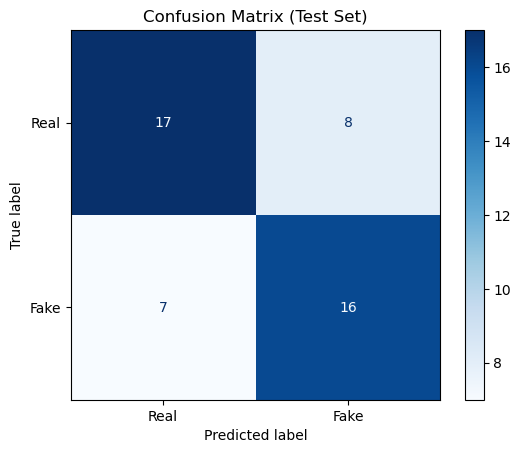

In [9]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set to eval mode
model.eval()
data = data.to(device)

# Make predictions
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)

# Get only test nodes
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])

# Plot
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [10]:
import joblib
torch.save(model.state_dict(), "gnn_model.pt")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
torch.save(data.x, "gnn_train_x.pt")

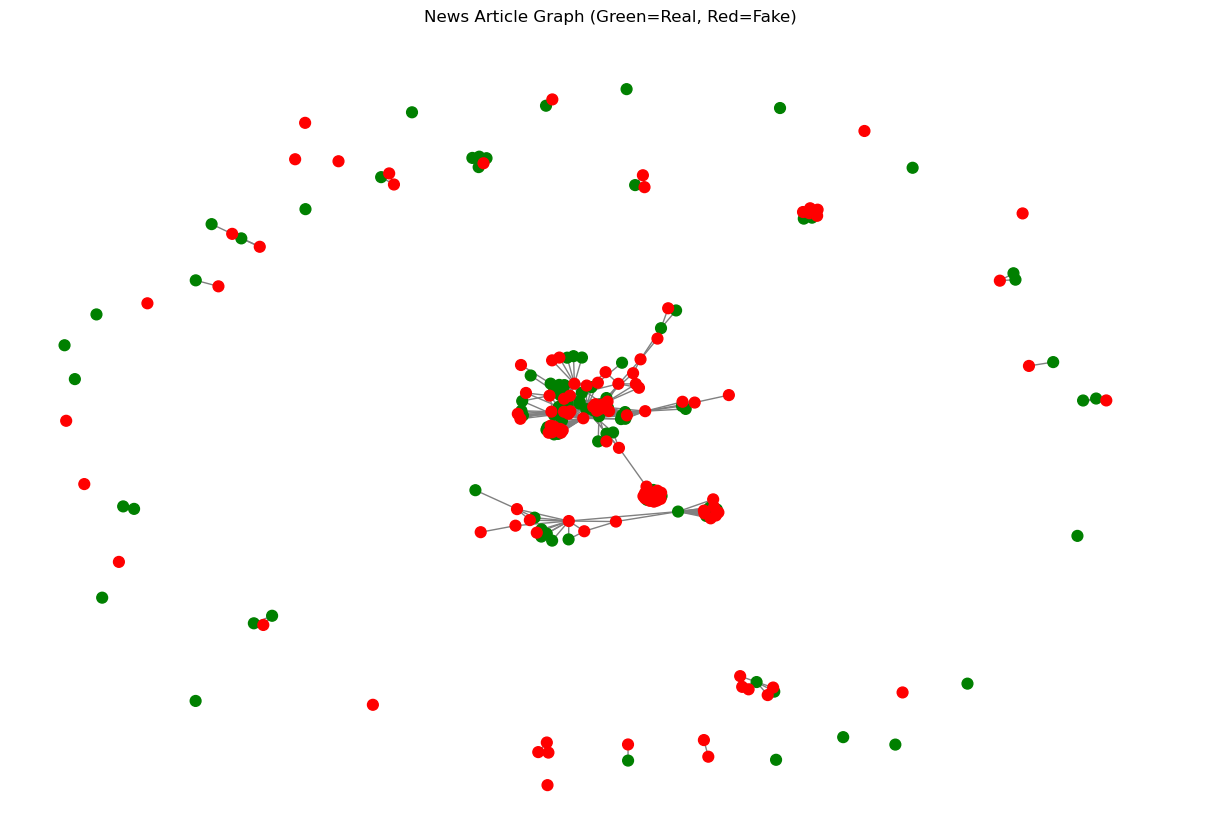

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert PyG Data object to NetworkX
G = to_networkx(data, to_undirected=True)

# Color nodes: green = real (0), red = fake (1)
labels = data.y.cpu().numpy()
colors = ['green' if label == 0 else 'red' for label in labels]

# Limit to a subgraph to avoid clutter
subset = list(range(min(1000, data.num_nodes)))
subG = G.subgraph(subset)

plt.figure(figsize=(12, 8))
nx.draw(subG, node_color=[colors[i] for i in subset], with_labels=False,
        node_size=60, edge_color='gray')
plt.title("News Article Graph (Green=Real, Red=Fake)")
plt.axis('off')
plt.show()


In [12]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data

def classify_article(article_text, vectorizer, data_x, model, device, top_k=5, threshold=0.7):
    input_vec = vectorizer.transform([article_text]).toarray()
    x_input = torch.tensor(input_vec, dtype=torch.float).to(device)

    # Find top-k similar articles
    sims = cosine_similarity(input_vec, data_x.cpu().numpy())[0]
    top_k_idx = np.argsort(sims)[-top_k:]

    # Create edge list: input to neighbors + mutual neighbors if similarity > threshold
    edge_list = [(0, i + 1) for i in range(top_k)] + [(i + 1, 0) for i in range(top_k)]
    for i in range(top_k):
        for j in range(i + 1, top_k):
            sim_ij = cosine_similarity(
                [data_x[top_k_idx[i]].cpu().numpy()],
                [data_x[top_k_idx[j]].cpu().numpy()]
            )[0][0]
            if sim_ij > threshold:
                edge_list += [(i + 1, j + 1), (j + 1, i + 1)]

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous().to(device)
    neighbor_feats = data_x[top_k_idx]
    x_combined = torch.cat([x_input, neighbor_feats], dim=0)
    data_infer = Data(x=x_combined, edge_index=edge_index).to(device)

    model.eval()
    with torch.no_grad():
        output = model(data_infer)
        probs = torch.softmax(output[0], dim=0)
        pred = torch.argmax(probs).item()
        return pred, probs.cpu().numpy()
